<a href="https://colab.research.google.com/github/Vasyl808/deepfake_video_detection/blob/main/dfdc_cnn_lstm_balanced_ready.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!gdown --fuzzy https://drive.google.com/file/d/1KdufS2RjKU0kHtc5vxm7nx8iiyL_-h2g/view?usp=sharing -O dfdc.zip

Downloading...
From (original): https://drive.google.com/uc?id=1KdufS2RjKU0kHtc5vxm7nx8iiyL_-h2g
From (redirected): https://drive.google.com/uc?id=1KdufS2RjKU0kHtc5vxm7nx8iiyL_-h2g&confirm=t&uuid=c72ea325-9de0-418b-ba9c-0b7023912bb2
To: /content/dfdc.zip
100% 4.44G/4.44G [01:03<00:00, 70.4MB/s]


In [3]:
!gdown --fuzzy https://drive.google.com/file/d/13GaVwQw_3fFYwoWc86oyhtlPEQjTQT69/view?usp=sharing -O archive_uadfv.zip

Downloading...
From (original): https://drive.google.com/uc?id=13GaVwQw_3fFYwoWc86oyhtlPEQjTQT69
From (redirected): https://drive.google.com/uc?id=13GaVwQw_3fFYwoWc86oyhtlPEQjTQT69&confirm=t&uuid=59e4bf43-327c-4322-88b4-2c2e10687ea9
To: /content/archive_uadfv.zip
100% 153M/153M [00:02<00:00, 51.7MB/s]


In [4]:
!pip install facenet_pytorch --no-deps

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 25.8 MB/s eta 0:00:00


In [5]:
!unzip /content/dfdc.zip

Archive:  /content/dfdc.zip
  inflating: sample_submission.csv   
  inflating: test_videos/aassnaulhq.mp4  
  inflating: test_videos/aayfryxljh.mp4  
  inflating: test_videos/acazlolrpz.mp4  
  inflating: test_videos/adohdulfwb.mp4  
  inflating: test_videos/ahjnxtiamx.mp4  
  inflating: test_videos/ajiyrjfyzp.mp4  
  inflating: test_videos/aktnlyqpah.mp4  
  inflating: test_videos/alrtntfxtd.mp4  
  inflating: test_videos/aomqqjipcp.mp4  
  inflating: test_videos/apedduehoy.mp4  
  inflating: test_videos/apvzjkvnwn.mp4  
  inflating: test_videos/aqrsylrzgi.mp4  
  inflating: test_videos/axfhbpkdlc.mp4  
  inflating: test_videos/ayipraspbn.mp4  
  inflating: test_videos/bcbqxhziqz.mp4  
  inflating: test_videos/bcvheslzrq.mp4  
  inflating: test_videos/bdshuoldwx.mp4  
  inflating: test_videos/bfdopzvxbi.mp4  
  inflating: test_videos/bfjsthfhbd.mp4  
  inflating: test_videos/bjyaxvggle.mp4  
  inflating: test_videos/bkcyglmfci.mp4  
  inflating: test_videos/bktkwbcawi.mp4  
  inflatin

In [6]:
!unzip /content/archive_uadfv.zip

Archive:  /content/archive_uadfv.zip
  inflating: fake_videos/test/fake/0046_fake.mp4  
  inflating: fake_videos/test/fake/0047_fake.mp4  
  inflating: fake_videos/test/fake/0048_fake.mp4  
  inflating: fake_videos/test/real/0046.mp4  
  inflating: fake_videos/test/real/0047.mp4  
  inflating: fake_videos/test/real/0048.mp4  
  inflating: fake_videos/train/fake/0000_fake.mp4  
  inflating: fake_videos/train/fake/0001_fake.mp4  
  inflating: fake_videos/train/fake/0002_fake.mp4  
  inflating: fake_videos/train/fake/0003_fake.mp4  
  inflating: fake_videos/train/fake/0004_fake.mp4  
  inflating: fake_videos/train/fake/0005_fake.mp4  
  inflating: fake_videos/train/fake/0006_fake.mp4  
  inflating: fake_videos/train/fake/0007_fake.mp4  
  inflating: fake_videos/train/fake/0008_fake.mp4  
  inflating: fake_videos/train/fake/0009_fake.mp4  
  inflating: fake_videos/train/fake/0010_fake.mp4  
  inflating: fake_videos/train/fake/0011_fake.mp4  
  inflating: fake_videos/train/fake/0012_fake.mp

In [24]:
import cv2
import itertools
import json
import numpy as np
import pandas as pd
import random
from torch.nn import functional as F
import os.path
import time
import torch
from torch import nn
from torch.nn import functional
import glob
import datetime
import subprocess
from scipy.io import wavfile
from facenet_pytorch import MTCNN
import shutil


class FaceDeepfakeDataset(torch.utils.data.Dataset):
    def __init__(self, folders, n_frames=None, n_audio_reads=50027, train=True, device=None, cache_folder='/content/cache'):
        """n_audio_reads controls the length of the audio sequence: 5000 readings/sec."""
        self.n_frames = n_frames
        self.n_audio_reads = n_audio_reads
        self.videos = []
        self.train = train
        self.device = device if device is not None else torch.device("cpu")
        self.cache_folder = cache_folder
        self.detector = MTCNN(device='cuda', post_process=False)

        # Створюємо директорію кешування, якщо вона не існує
        if cache_folder and not os.path.exists(cache_folder):
            os.makedirs(cache_folder)

        for i in range(len(folders)):
            if train:
                if i == 0:
                    with open('/content/train_sample_videos/metadata.json') as f:
                        videos = json.load(f)
                        videos = [(os.path.join(folders[i], video), metadata) for (video, metadata) in videos.items()]
                        self.videos += videos
                else:
                    with open(os.path.join("/content/test.json")) as f:
                        videos = json.load(f)
                        videos = [(os.path.join(folders[i], video), metadata) for (video, metadata) in videos.items()]
                        self.videos += videos[:226]
            else:
                self.videos += glob.glob(folders[i] + "/*.mp4")

    def __process_frame(self, frame, video_id, frame_idx):
        cache_path = os.path.join(self.cache_folder, f"{video_id}_frame{frame_idx}.pt") if self.cache_folder else None

        # Якщо файл з кешем існує, завантажуємо його
        if cache_path and os.path.exists(cache_path):
            return torch.load(cache_path)

        # Інакше обробляємо кадр
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        boxes, _ = self.detector.detect(frame, landmarks=False)

        if boxes is None:
            return None
        else:
            box = boxes[0]
            width = box[2] - box[0]
            height = box[3] - box[1]
            expand_x = width * 0.3 / 2
            expand_y = height * 0.3 / 2
            x1 = max(int(box[0] - expand_x), 0)
            y1 = max(int(box[1] - expand_y), 0)
            x2 = min(int(box[2] + expand_x), frame.shape[1])
            y2 = min(int(box[3] + expand_y), frame.shape[0])

            face = frame[y1:y2, x1:x2]
            face = cv2.resize(face, (300, 300))
            face = torch.from_numpy(face).permute(2, 0, 1).float() / 255.0

            # Зберігаємо оброблений кадр у кеш
            if cache_path:
                torch.save(face, cache_path)

            return face

    def __pad_or_trim_frames(self, frames):
        if len(frames) == self.n_frames:
            return frames
        elif len(frames) < self.n_frames:
            # Дублюємо кадри, поки не досягнемо необхідної кількості
            num_repeats = (self.n_frames) // len(frames) + 1
            frames = frames * num_repeats
            frames = frames[:self.n_frames]
        elif len(frames) > self.n_frames:
            # Залишаємо тільки перші 30 кадрів
            frames = frames[:self.n_frames]
        return frames

    def __getitem__(self, n):
        if self.train:
            video, metadata = self.videos[n]
        else:
            video = self.videos[n]

        video_id = os.path.splitext(os.path.basename(video))[0]
        cap = cv2.VideoCapture(video)

        frames = []
        frame_idx = 0
        while len(frames) < self.n_frames:
            ret, frame = cap.read()
            if not ret:
                break

            processed_frame = self.__process_frame(frame, video_id, frame_idx)
            if processed_frame is not None:
                frames.append(processed_frame)
            frame_idx += 1

        cap.release()
        frames = self.__pad_or_trim_frames(frames)
        frames = torch.stack(frames).to(self.device)

        if self.train:
            label = 0.0 if metadata['label'] == 'REAL' else 1.0
            return frames, torch.FloatTensor([label]).to(self.device)
        else:
            return frames

    def __len__(self):
        return len(self.videos)

In [25]:
class FaceDeepfakeDatasetTest(torch.utils.data.Dataset):
    def __init__(self, folders, n_frames=None, n_audio_reads=50027, train=True, device=None, cache_folder=None):
        """n_audio_reads controls the length of the audio sequence: 5000 readings/sec."""
        self.n_frames = n_frames
        self.n_audio_reads = n_audio_reads
        self.videos = []
        self.train = train
        self.device = device if device is not None else torch.device("cpu")
        self.cache_folder = cache_folder
        self.detector = MTCNN(device='cpu', post_process=False)
        for i in range(len(folders)):
            if train:
                #print(folders[i])
                for item in os.listdir(folders[i]):
                    item_path = os.path.join(folders[i], item)
                    if str(os.path.basename(item_path)) == 'fake':
                        for curr in os.listdir(item_path):
                            if os.path.isfile(os.path.join(item_path, curr)):
                                metadata = {}
                                metadata['label']='fake'
                                self.videos += [(os.path.join(item_path, curr), metadata)]
                    else:
                        for item_file in os.listdir(item_path):
                            if os.path.isfile(os.path.join(item_path, item_file)):
                                metadata = {}
                                metadata['label']='real'
                                self.videos += [(os.path.join(item_path, item_file), metadata)]
            else:
                self.videos += glob.glob(folders[i] + "/*.mp4")

    def __process_frame(self, frame):
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        boxes, _ = self.detector.detect(frame, landmarks=False)  # Отримуємо координати обличчя

        if boxes is None:
            # Повертаємо порожній кадр, якщо обличчя не знайдено
            face = torch.zeros((3, 300, 300))
        else:
            # Беремо перше обличчя (якщо знайдено кілька)
            box = boxes[0]

            # Розширюємо рамку на 30%
            width = box[2] - box[0]
            height = box[3] - box[1]
            expand_x = width * 0.3 / 2
            expand_y = height * 0.3 / 2
            x1 = max(int(box[0] - expand_x), 0)
            y1 = max(int(box[1] - expand_y), 0)
            x2 = min(int(box[2] + expand_x), frame.shape[1])
            y2 = min(int(box[3] + expand_y), frame.shape[0])

            # Обрізаємо зображення за новими координатами
            face = frame[y1:y2, x1:x2]
            face = cv2.resize(face, (300, 300))  # Масштабуємо до 300x300

            # Перетворюємо на тензор і нормалізуємо
            face = torch.from_numpy(face).permute(2, 0, 1).float() / 255.0

        return face

    def __getitem__(self, n):
        if self.train:
            video, metadata = self.videos[n]
        else:
            video = self.videos[n]

        # Processing video frames
        if os.path.islink(video):
            video = os.readlink(video)

        cap = cv2.VideoCapture(video)

        frames = []
        for _ in range(self.n_frames):
            ret, frame = cap.read()
            if not ret:
                break
            frames.append(self.__process_frame(frame))
        '''total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        step = max(1, total_frames // self.n_frames)

        for i in range(self.n_frames):
            cap.set(cv2.CAP_PROP_POS_FRAMES, i * step)
            ret, frame = cap.read()
            if ret:
                frames.append(self.__process_frame(frame))
            else:
                break'''
        cap.release()
        frames = torch.stack(frames).to(self.device)

        # Return data
        if self.train:
            label = 0.0
            if metadata['label'] == 'fake':
                label = 1.0
            return frames, torch.FloatTensor([label]).to(self.device)
        else:
            return frames

    def __len__(self):
        return len(self.videos)


'''def __process_frame(self, frame):
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    boxes, _ = self.detector.detect(frame, landmarks=False)  # Отримуємо координати обличчя

    if boxes is None:
        # Повертаємо None, якщо обличчя не знайдено
        return None
    else:
        # Беремо перше обличчя (якщо знайдено кілька)
        box = boxes[0]

        # Розширюємо рамку на 30%
        width = box[2] - box[0]
        height = box[3] - box[1]
        expand_x = width * 0.3 / 2
        expand_y = height * 0.3 / 2
        x1 = max(int(box[0] - expand_x), 0)
        y1 = max(int(box[1] - expand_y), 0)
        x2 = min(int(box[2] + expand_x), frame.shape[1])
        y2 = min(int(box[3] + expand_y), frame.shape[0])

        # Обрізаємо зображення за новими координатами
        face = frame[y1:y2, x1:x2]
        face = cv2.resize(face, (300, 300))  # Масштабуємо до 300x300

        # Перетворюємо на тензор і нормалізуємо
        face = torch.from_numpy(face).permute(2, 0, 1).float() / 255.0

        return face

def __getitem__(self, n):
    if self.train:
        video, metadata = self.videos[n]
    else:
        video = self.videos[n]

    # Processing video frames
    if os.path.islink(video):
        video = os.readlink(video)

    cap = cv2.VideoCapture(video)

    frames = []
    while len(frames) < self.n_frames:
        ret, frame = cap.read()
        if not ret:
            # Якщо дійшли до кінця відео, повертаємось на початок
            cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
            continue

        processed_frame = self.__process_frame(frame)
        if processed_frame is not None:
            frames.append(processed_frame)

    cap.release()
    frames = torch.stack(frames).to(self.device)

    # Return data
    if self.train:
        label = 0.0
        if metadata['label'] == 'fake':
            label = 1.0
        return frames, torch.FloatTensor([label]).to(self.device)
    else:
        return frames

def __len__(self):
    return len(self.videos)'''

"def __process_frame(self, frame):\n    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)\n    boxes, _ = self.detector.detect(frame, landmarks=False)  # Отримуємо координати обличчя\n\n    if boxes is None:\n        # Повертаємо None, якщо обличчя не знайдено\n        return None\n    else:\n        # Беремо перше обличчя (якщо знайдено кілька)\n        box = boxes[0]\n\n        # Розширюємо рамку на 30%\n        width = box[2] - box[0]\n        height = box[3] - box[1]\n        expand_x = width * 0.3 / 2\n        expand_y = height * 0.3 / 2\n        x1 = max(int(box[0] - expand_x), 0)\n        y1 = max(int(box[1] - expand_y), 0)\n        x2 = min(int(box[2] + expand_x), frame.shape[1])\n        y2 = min(int(box[3] + expand_y), frame.shape[0])\n\n        # Обрізаємо зображення за новими координатами\n        face = frame[y1:y2, x1:x2]\n        face = cv2.resize(face, (300, 300))  # Масштабуємо до 300x300\n\n        # Перетворюємо на тензор і нормалізуємо\n        face = torch.from_numpy(

In [17]:
!gdown --fuzzy https://drive.google.com/file/d/1-3NNxczq2DfAMp7EYf5J7Axu-zxIsC5K/view?usp=sharing

Downloading...
From (original): https://drive.google.com/uc?id=1-3NNxczq2DfAMp7EYf5J7Axu-zxIsC5K
From (redirected): https://drive.google.com/uc?id=1-3NNxczq2DfAMp7EYf5J7Axu-zxIsC5K&confirm=t&uuid=f10f38eb-e090-40b0-a367-9a44ed5cd08d
To: /content/maybe_done_dfdc_balanced_4_classifier_30_small.pt
100% 282M/282M [00:02<00:00, 107MB/s]


In [22]:
import torch
import torch.nn as nn
import math
from torch.nn import functional as F
import torchvision.models as models


class FaceClassifier(nn.Module):
    def __init__(self, n_linear_hidden=256, lstm_hidden_dim=128, num_lstm_layers=3, dropout=0.4):
        super(FaceClassifier, self).__init__()

        # Завантаження попередньо натренованої EfficientNet
        self.cnn = models.efficientnet_b7(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(self.cnn.children())[:-1])  # Виключаємо шар класифікації

        # Розмір виходу від feature extractor
        self.feature_output_size = 2560  # EfficientNet B7 дає 2560 ознак

        # LSTM для обробки послідовності ознак кожного кадру
        self.lstm = nn.LSTM(input_size=self.feature_output_size,
                            hidden_size=lstm_hidden_dim,
                            num_layers=num_lstm_layers,
                            dropout=dropout,
                            batch_first=True,
                            bidirectional=True)

        # Повнозв'язні шари для класифікації
        self.fc1 = nn.Linear(2 * lstm_hidden_dim, n_linear_hidden)  # множимо на 2 через bidirectional LSTM
        self.fc2 = nn.Linear(n_linear_hidden, 1)

    def forward(self, vid_frames):
        # Витягання ознак для кожного кадру
        batch_size, num_frames, channels, height, width = vid_frames.shape
        vid_frames = vid_frames.view(batch_size * num_frames, channels, height, width)

        # Використовуємо фічерний екстрактор
        with torch.no_grad():
            vid_features = self.feature_extractor(vid_frames)

        # Переформатовуємо ознаки для LSTM
        vid_features = vid_features.view(batch_size, num_frames, -1)  # (batch_size, num_frames, feature_output_size)

        # Обробка послідовності кадрів через LSTM
        lstm_out, _ = self.lstm(vid_features)  # lstm_out: (batch_size, num_frames, 2 * lstm_hidden_dim)

        # Використання середнього значення по кадрам для об'єднання послідовності (можна також використовувати останній кадр або інші методи агрегації)
        lstm_out = torch.mean(lstm_out, dim=1)  # (batch_size, 2 * lstm_hidden_dim)

        # Класифікаційні шари
        x = torch.relu(self.fc1(lstm_out))
        x = self.fc2(x)

        return x

all train folders: ['/content/train_sample_videos', '/content/test_videos'], <class 'list'>
all test folders: ['/content/fake_videos/train'], <class 'list'>


<ipython-input-23-d4ca04d96c2d>:59: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/maybe_done_dfdc_balanced_4_classifier_30_small.p

start time: 2024-11-08 14:26:26.082273
using device: cuda
79


0it [00:00, ?it/s]<ipython-input-20-ed5f67add7ec>:56: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(cache_path)
79it [42:15, 32.10s/it]


[[274  29]
 [ 13 310]]
Classification Report (Train Set):
              precision    recall  f1-score   support

        Real       0.95      0.90      0.93       303
        Fake       0.91      0.96      0.94       323

    accuracy                           0.93       626
   macro avg       0.93      0.93      0.93       626
weighted avg       0.93      0.93      0.93       626


epoch: 0, train loss: 0.2028832625644871, valid loss: 1.4570707038722255 executed in: 2929.037575483322
train total: 626, train correct: 584.0, train incorrect: 42.0, train accuracy: 0.9329073429107666
valid total: 82, valid correct: 51.0, valid incorrect: 31.0, valid accuracy: 0.6219512224197388


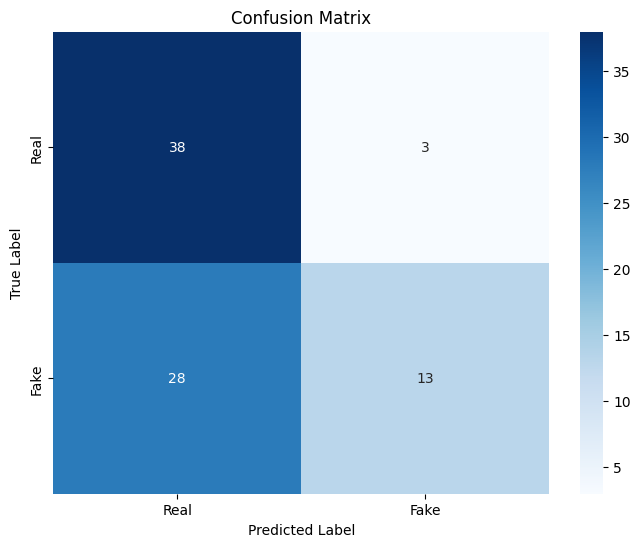

Classification Report:
              precision    recall  f1-score   support

        Real       0.58      0.93      0.71        41
        Fake       0.81      0.32      0.46        41

    accuracy                           0.62        82
   macro avg       0.69      0.62      0.58        82
weighted avg       0.69      0.62      0.58        82



0it [00:00, ?it/s]<ipython-input-20-ed5f67add7ec>:56: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(cache_path)
79it [16:19, 12.40s/it]


[[279  24]
 [ 15 308]]
Classification Report (Train Set):
              precision    recall  f1-score   support

        Real       0.95      0.92      0.93       303
        Fake       0.93      0.95      0.94       323

    accuracy                           0.94       626
   macro avg       0.94      0.94      0.94       626
weighted avg       0.94      0.94      0.94       626


epoch: 1, train loss: 0.15804444565850345, valid loss: 1.1350464733656158 executed in: 1371.047259569168
train total: 626, train correct: 587.0, train incorrect: 39.0, train accuracy: 0.9376996755599976
valid total: 82, valid correct: 45.0, valid incorrect: 37.0, valid accuracy: 0.5487804412841797


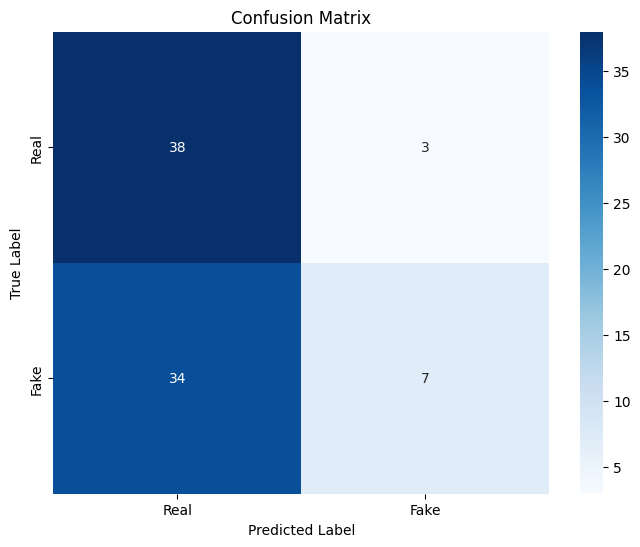

Classification Report:
              precision    recall  f1-score   support

        Real       0.53      0.93      0.67        41
        Fake       0.70      0.17      0.27        41

    accuracy                           0.55        82
   macro avg       0.61      0.55      0.47        82
weighted avg       0.61      0.55      0.47        82



0it [00:00, ?it/s]<ipython-input-20-ed5f67add7ec>:56: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(cache_path)
79it [16:09, 12.27s/it]


[[282  21]
 [ 16 307]]
Classification Report (Train Set):
              precision    recall  f1-score   support

        Real       0.95      0.93      0.94       303
        Fake       0.94      0.95      0.94       323

    accuracy                           0.94       626
   macro avg       0.94      0.94      0.94       626
weighted avg       0.94      0.94      0.94       626


epoch: 2, train loss: 0.17108262709306576, valid loss: 1.2286843218501995 executed in: 1362.9655420780182
train total: 626, train correct: 589.0, train incorrect: 37.0, train accuracy: 0.9408945441246033
valid total: 82, valid correct: 49.0, valid incorrect: 33.0, valid accuracy: 0.5975609421730042


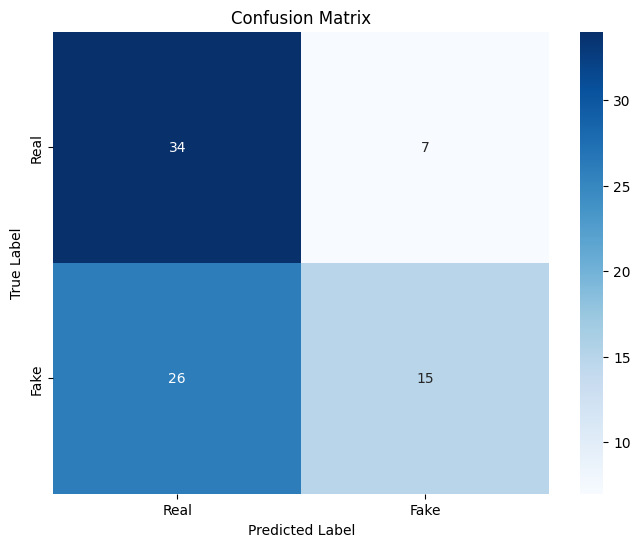

Classification Report:
              precision    recall  f1-score   support

        Real       0.57      0.83      0.67        41
        Fake       0.68      0.37      0.48        41

    accuracy                           0.60        82
   macro avg       0.62      0.60      0.57        82
weighted avg       0.62      0.60      0.57        82



0it [00:00, ?it/s]<ipython-input-20-ed5f67add7ec>:56: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(cache_path)
79it [16:14, 12.33s/it]


[[283  20]
 [ 13 310]]
Classification Report (Train Set):
              precision    recall  f1-score   support

        Real       0.96      0.93      0.94       303
        Fake       0.94      0.96      0.95       323

    accuracy                           0.95       626
   macro avg       0.95      0.95      0.95       626
weighted avg       0.95      0.95      0.95       626


epoch: 3, train loss: 0.14958904368826484, valid loss: 1.0743213137611747 executed in: 1380.0264627933502
train total: 626, train correct: 593.0, train incorrect: 33.0, train accuracy: 0.9472843408584595
valid total: 82, valid correct: 42.0, valid incorrect: 40.0, valid accuracy: 0.5121951103210449


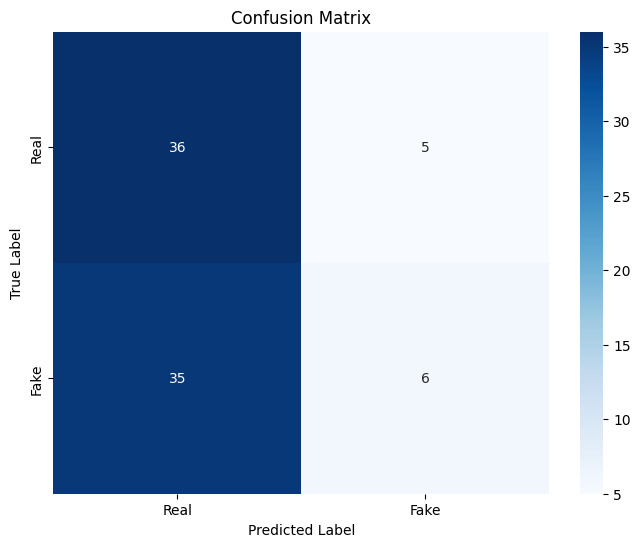

Classification Report:
              precision    recall  f1-score   support

        Real       0.51      0.88      0.64        41
        Fake       0.55      0.15      0.23        41

    accuracy                           0.51        82
   macro avg       0.53      0.51      0.44        82
weighted avg       0.53      0.51      0.44        82



0it [00:00, ?it/s]<ipython-input-20-ed5f67add7ec>:56: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(cache_path)
79it [16:28, 12.51s/it]


[[286  17]
 [  6 317]]
Classification Report (Train Set):
              precision    recall  f1-score   support

        Real       0.98      0.94      0.96       303
        Fake       0.95      0.98      0.96       323

    accuracy                           0.96       626
   macro avg       0.96      0.96      0.96       626
weighted avg       0.96      0.96      0.96       626


epoch: 4, train loss: 0.11800777501002237, valid loss: 0.8475103841628879 executed in: 1403.2144947052002
train total: 626, train correct: 603.0, train incorrect: 23.0, train accuracy: 0.9632587432861328
valid total: 82, valid correct: 41.0, valid incorrect: 41.0, valid accuracy: 0.4999999701976776


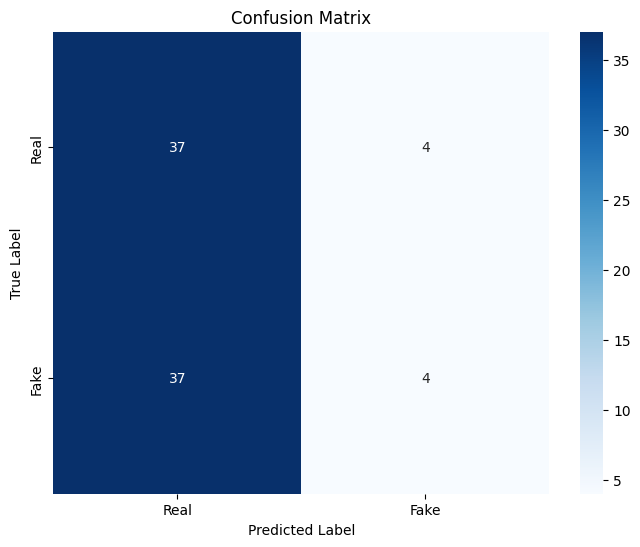

Classification Report:
              precision    recall  f1-score   support

        Real       0.50      0.90      0.64        41
        Fake       0.50      0.10      0.16        41

    accuracy                           0.50        82
   macro avg       0.50      0.50      0.40        82
weighted avg       0.50      0.50      0.40        82

end time: 2024-11-08 16:47:37.253996
executed in: 2:21:11.171723
Tesla T4
Memory Usage:
Allocated: 0.4 GB
Cached:    12.7 GB


<ipython-input-23-d4ca04d96c2d>:236: FutureWarning: `torch.cuda.memory_cached` has been renamed to `torch.cuda.memory_reserved`
  print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')


In [23]:
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
import datetime
import sys
import pandas as pd
import os
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision

base_path = 'deepfake-detection-challenge'

#train_folder = os.listdir(str(sys.argv[1]))
train_folders = ['/content/train_sample_videos', '/content/test_videos']


#test_folder = os.listdir(str(sys.argv[2]))
test_folders = [os.path.join("/content/", "fake_videos", "train")]

batch_size = int(8)
num_epochs = int(5)
n_frames = int(30)
lr = float(0.001)

TRAIN_FOLDERS = train_folders
TEST_FOLDERS = test_folders
print(f"all train folders: {train_folders}, {type(train_folders)}")
print(f"all test folders: {test_folders}, {type(test_folders)}")
# AUTOENCODER = 'autoencoder_H10M46S22_04-11-21.pt'

# batch_size = 10
# num_epochs = 1
# epoch_size = 500
# n_frames = 30
milestones = [6,12,18]
gamma = 0.1
n_vid_features = 36*36 # 3600
n_aud_features = 1
n_head = 8
n_layers = 6

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#autoencoder = FaceAutoencoder()
#if len(sys.argv) > 7:
#    print("pretrained autoencoder is loaded")
#    AUTOENCODER = str(sys.argv[7])
#    autoencoder.load_state_dict(torch.load(AUTOENCODER, map_location=device))
#autoencoder.to(device)
#autoencoder.eval()

model = FaceClassifier()
model.load_state_dict(torch.load('/content/maybe_done_dfdc_balanced_4_classifier_30_small.pt', map_location=device))
model = model.to(device)
class_weights = {0: 0.6191950464396285, 1: 2.5974025974025974}
weights_tensor = torch.tensor([class_weights[0], class_weights[1]], dtype=torch.float32).to(device)

# Modify the loss function
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma)

start_time = datetime.datetime.now()
print(f'start time: {str(start_time)}')
print(f'using device: {device}')

'''Splitting into Train and Validation'''
train_dataset = FaceDeepfakeDataset(TRAIN_FOLDERS,  n_frames=n_frames, n_audio_reads=576, device=device, cache_folder="face_encode_cache")
test_dataset = FaceDeepfakeDatasetTest(TEST_FOLDERS, n_frames=n_frames, n_audio_reads=576, device=device)
# dataset_size = len(dataset)
# val_split = .3
# val_size = int(val_split * dataset_size)
# train_size = dataset_size - val_size
# train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
print(len(train_loader))
#dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

'''Train_Loop'''
train_losses = []
val_losses = []
best_loss = np.inf
train_accuracies = []
val_accuracies = []
epoch_times = []


for epoch in range(num_epochs):
    epoch_start_time = time.time()
    epoch_t_loss = 0
    epoch_v_loss = 0
    t_count = 0
    t_count_wrong = 0
    train_labels_all = []
    train_preds_all = []

    model.train()
    torch.cuda.empty_cache()
    for i, batch in tqdm(enumerate(train_loader)):
        # if i * batch_size >= epoch_size:
        #     break
        video_data, labels = batch
        video_data = video_data.to(device)
        #audio_data = audio_data.to(device)

        output = model(video_data)
        loss = criterion(output, labels)

        output = torch.sigmoid(output)
        output = output.round()

        n_wrong = (labels - output).abs().sum()
        t_count_wrong += n_wrong
        t_count += labels.shape[0]

        epoch_t_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_labels_all.extend(labels.cpu().detach().numpy())
        train_preds_all.extend(output.cpu().detach().numpy())

        #print('.', end='', flush=True)
        torch.cuda.empty_cache()

    # Перетворіть на numpy-масиви
    train_labels_all = np.array(train_labels_all).astype(int)
    train_preds_all = np.array(train_preds_all).astype(int)

    # Обчисліть та виведіть матрицю плутанини для тренувального набору
    conf_matrix_train = confusion_matrix(train_labels_all, train_preds_all)
    print(conf_matrix_train)
    # plt.figure(figsize=(8, 6))
    #sns.heatmap(conf_matrix_train, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
    #plt.xlabel('Predicted Label')
    #plt.ylabel('True Label')
    #plt.title('Confusion Matrix (Train Set)')
    #plt.show()

    # Виведіть класифікаційний звіт для тренувального набору
    print("Classification Report (Train Set):")
    print(classification_report(train_labels_all, train_preds_all, target_names=['Real', 'Fake']))

    all_labels = []
    all_preds = []

    model.eval()
    with torch.no_grad():
        v_count = 0
        v_count_wrong = 0
        for i, batch in enumerate(val_loader):
            # if i * batch_size >= epoch_size:
        #        break
            video_data, labels = batch
            video_data = video_data.to(device)
            #audio_data = audio_data.to(device)
            # optimizer.zero_grad()
            output = model(video_data)
            loss = criterion(output, labels)

            output = torch.sigmoid(output)
            output = output.round()
            n_wrong = (labels - output).abs().sum()
            v_count_wrong += n_wrong
            v_count += labels.shape[0]

            epoch_v_loss += loss.item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(output.cpu().numpy())

            #loss.backward()
            #optimizer.step()
            #print('.', end='', flush=True)

    epoch_end_time = time.time()
    epoch_exec_time = epoch_end_time - epoch_start_time
    epoch_times.append(epoch_exec_time)
    train_losses.append(epoch_t_loss/len(train_loader))
    val_losses.append(epoch_t_loss/len(val_loader))

    t_count_right = t_count - t_count_wrong
    v_count_right = v_count - v_count_wrong
    t_accuracy = t_count_right / t_count
    v_accuracy = v_count_right / v_count

    train_accuracies.append(t_accuracy)
    val_accuracies.append(v_accuracy)

    print(f'\nepoch: {epoch}, train loss: {train_losses[-1]}, valid loss: {val_losses[-1]} executed in: {str(epoch_exec_time)}')
    print(f"train total: {t_count}, train correct: {t_count_right}, train incorrect: {t_count_wrong}, train accuracy: {t_accuracy}")
    print(f"valid total: {v_count}, valid correct: {v_count_right}, valid incorrect: {v_count_wrong}, valid accuracy: {v_accuracy}")
    all_labels = np.array(all_labels).astype(int)
    all_preds = np.array(all_preds).astype(int)
    # Обчислення та візуалізація матриці плутанини
    conf_matrix = confusion_matrix(all_labels, all_preds)
    #print(conf_matrix)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    # Друк звіту про класифікацію
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=['Real', 'Fake']))

    scheduler.step()
    ### Saving model per best validation loss
    if best_loss > train_losses[-1]:
        best_loss = train_losses[-1]
        end_time = datetime.datetime.now()
        torch.save(model.state_dict(), f'/content/drive/MyDrive/dfdc_balanced_{epoch + 5}_classifier_{n_frames}_small.pt')
    torch.save(model.state_dict(), f'/content/drive/MyDrive/dfdc_balanced_{epoch + 5}_classifier_{n_frames}_small.pt')


end_time = datetime.datetime.now()
print(f"end time: {str(end_time)}")
exec_time = end_time - start_time
print(f"executed in: {str(exec_time)}")
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

#df = pd.DataFrame()
#df['train_loss'] = train_losses.cpu().numpy()
#df['val_loss'] = val_losses.cpu().numpy()
#df['train_acc'] = train_accuracies.cpu().numpy()
#df['val_acc'] = val_accuracies.cpu().numpy()
#df['epoch_times'] = epoch_times

#df.to_csv(f'train_classifier_nframes{n_frames}_bs{batch_size}_lr{lr}.csv', index=False)


In [ ]:
torch.save(model.state_dict(), f'/content/drive/MyDrive/dfdc_balanced_{1}_classifier_{30}_small.pt')

In [ ]:
torch.save(model.state_dict(), f'/content/drive/MyDrive/10_epochs_classifier_30_small_batch_8_dfdc.pt')